<a href="https://colab.research.google.com/github/ShanjinurIslam/Deep-Learning/blob/master/Dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog breed identification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

##1. Problem

Identifying Breed of a dog given an image of a dog

##2. Data

The data we're using is from Kaggle's dog breed indentification competition

##3. Evaluation

Prediction Probabilities for each dog breed of each test image

##4. Features

* Images
* Unstructured Data

### Get our workspace ready

1.   Import TensorFlow
2.   Import TensorFlow Hub
3.   Make sure we're using a GPU




In [221]:
# import TensorFlow into Colab
import numpy as np


import tensorflow as tf
print("TF Version: ",tf.__version__)

import tensorflow_hub as hub
print("TF Version: ",hub.__version__)


# Check for GPU Availibility

print(tf.config.list_physical_devices("GPU"))

TF Version:  2.2.0-rc1
TF Version:  0.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 ## Getting our data ready (turning in Tensors)

 Turning our images in tensors (numerical representation)

In [222]:
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Breed Identification/labels.csv")
labels_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
id       10222 non-null object
breed    10222 non-null object
dtypes: object(2)
memory usage: 159.8+ KB


In [223]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


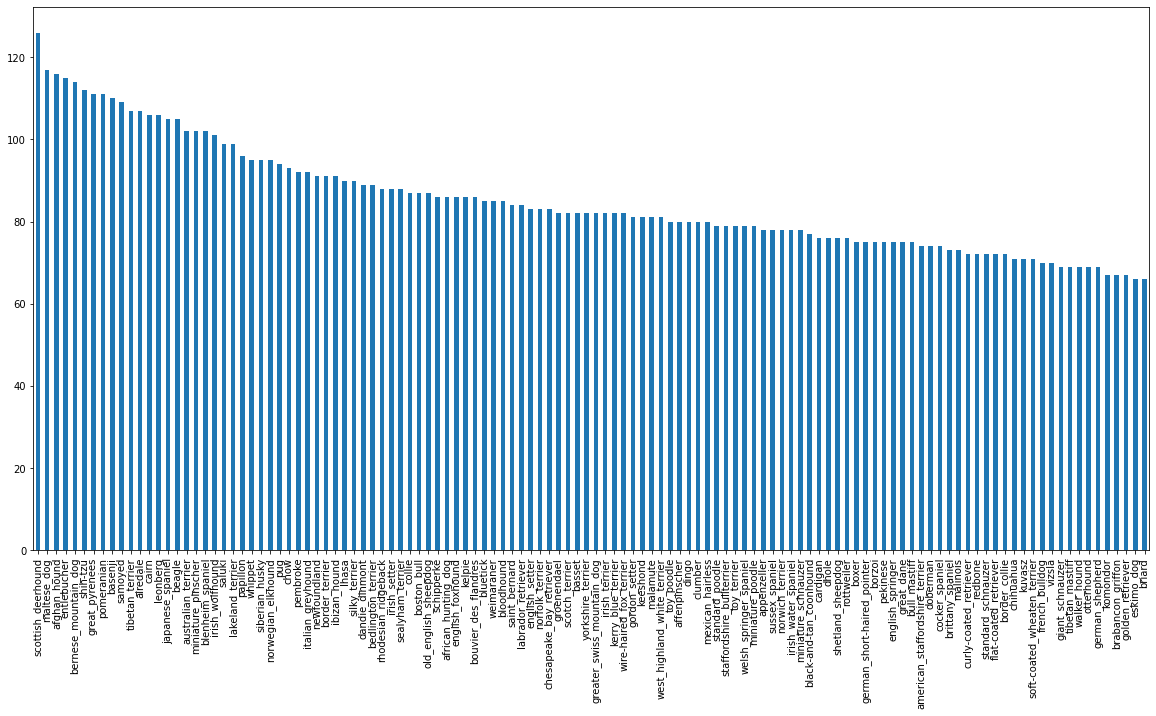

In [224]:
labels_csv.breed.value_counts().plot.bar(figsize=(20,10))

In [225]:
labels_csv.breed.value_counts().median()

82.0

In [0]:
# Preparing the images

In [227]:
from IPython.display import Image
Image('drive/My Drive/Dog Breed Identification/0a0c223352985ec154fd604d7ddceabd.jpg')

# Getting Images and their label

Let's get a list of all image file path names

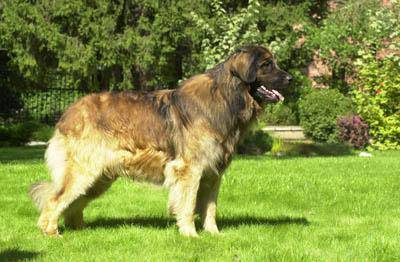

In [228]:
filenames = ['drive/My Drive/Dog Breed Identification/train/'+str(fname)+'.jpg' for fname in labels_csv.id]
Image(filenames[255])

## Turning labels in boolean array

1.    Since we got our filenames
2.    Let's prepare our labels

In [229]:
unique_breeds = np.unique(labels_csv.breed)
unique_breeds
len(unique_breeds)

120

In [0]:
# Turn single label intro an array of boolean/integers

label_arr = [label == unique_breeds for label in labels]
#label_arr = [np.array(label == unique_breeds).astype(int) for label in labels]


# Creating our own validation set

In [231]:
X = filenames
y = label_arr

len(X)

10222

We are going to start of our experiment with ~1000 images and increase as needed

In [0]:
# Set number of images for experimenting

NUM_IMAGES = 10000 #@param {type:"slider",min:1000,max:10000,step:1000}

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=.2,random_state=42)

In [234]:
len(X_train),len(X_val),len(y_train),len(y_val)

(8000, 2000, 8000, 2000)

# Preprocess Images 
** Turning images in Tensors

To preprocess our images into Tensors we're going to write a function which does a few things

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
4. Turn `image` to Tensors
4. Turn our `image` to be a shape of (224,224)
5. Return the modified `image`

In [235]:
 from matplotlib.pyplot import imread
 image = imread(filenames[42])
 image.shape

(257, 350, 3)

In [236]:
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [0]:
#1. Take an image filepath as input
#2. Use TensorFlow to read the file and save it to a variable, `image`
#3. Turn `image` to Tensors
#4. Turn our `image` to be a shape of (224,224)
#5. Return the modified `image`

# Define image size
IMG_SIZE = 224 #@param {type:"slider",min:224,max:304,step:16}


In [0]:
def process_image(image_path,img_size=IMG_SIZE):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.convert_image_dtype(image,tf.float32)
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

## Turning our data into batches

In order to use TensorFlow effectively, we need our data in form of Tensor tuples which look like this

`(image,label)`

In [0]:
def get_image_label_tuple(image_path,label):
  image = process_image(image_path,IMG_SIZE)

  return image,(label)

In [240]:
get_image_label_tuple(filenames[42],arr[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [0]:
BATCH_SIZE = 32 #@param {type:"slider",min:32,max:64,step:16}

In [0]:
# Create a function to turn data into batches
def create_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  # y is None when creating batch test sample
  # validation set is not shuffled
  if test_data:
    print("Creating test dataset batch")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(IMAGE_SIZE)
    return data_batch
  elif valid_data:
    print("Creating validation dataset batch")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch = data.map(get_image_label_tuple).batch(IMG_SIZE)
    return data_batch
  else:
    print("Creating training dataset batch")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label_tuple).batch(IMG_SIZE)
    return data_batch

In [243]:
train_data = create_batches(X_train,y_train)
validation_data = create_batches(X_train,y_train,valid_data=True)

Creating training dataset batch
Creating validation dataset batch


In [244]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

ERROR! Session/line number was not unique in database. History logging moved to new session 63
